In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler

In [17]:
df = pd.read_csv('E:\\Shirin Gangal\\Python\\Python_learning\\Udemy ML\\fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [19]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [20]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [21]:
# Convert categorical data to numeric format using one-hot encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

#df = pd.get_dummies(df, columns=['type'], drop_first=True)

Multicollinearity: Computed correlation matrix and displayed it. Removed columns which have > 0.90 correlation.


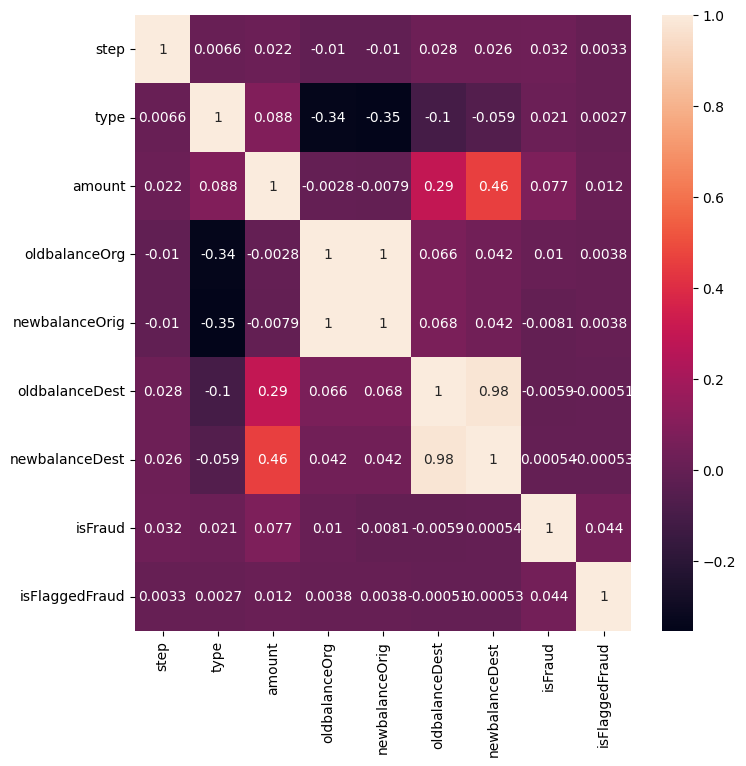

In [22]:
plt.figure(figsize= (8,8))
corr_fig = df.corr()
sns.heatmap(corr_fig, annot=True)
plt.show()

In [23]:
cols_to_drop = set()
corr_matrix = df.corr(numeric_only=True)
threshold = 0.95

# Loop through each pair of features
for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 != col2:
            corr_value = corr_matrix.loc[col1, col2]
            if abs(corr_value) > threshold:
                # Drop the second column (arbitrarily)
                cols_to_drop.add(col2)
print(cols_to_drop)

{'oldbalanceDest', 'newbalanceDest', 'oldbalanceOrg', 'newbalanceOrig'}


In [16]:
data = df
df.drop(['newbalanceOrig', 'newbalanceDest'], axis=1, inplace=True)
df.head()

,step,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,0.0,0,0,False,False,True,False
1,1,1864.28,21249.0,0.0,0,0,False,False,True,False
2,1,181.00,181.0,0.0,1,0,False,False,False,True
3,1,181.00,181.0,21182.0,1,0,True,False,False,False
4,1,11668.14,41554.0,0.0,0,0,False,False,True,False


Outliers:
For numeric features, outliers are detected using the Interquartile Range (IQR) method. Observations lying outside 
1.5*IQR are considered outliers and are removed from the dataset. This reduces noise and prevents skewed model learning.


In [38]:
def count_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((df[col] < lower) | (df[col] > upper))



In [24]:
df['log_amount'] = np.log1p(df['amount'])

In [36]:
Q1 = df['log_amount'].quantile(0.25)
Q3 = df['log_amount'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Get Boolean mask of outliers
outlier_mask = (df['log_amount'] < lower) | (df['log_amount'] > upper)

# Display outlier rows
outliers_df = df[outlier_mask]
print(outliers_df[['amount', 'log_amount', 'isFraud']])
zero_outliers = outliers_df[outliers_df['amount']==0]
print(zero_outliers[['amount','log_amount','isFraud']])

         amount  log_amount  isFraud
2        181.00    5.204007        1
3        181.00    5.204007        1
56        38.66    3.680343        0
125        8.73    2.275214        0
130       25.12    3.262701        0
...         ...         ...      ...
6362140   78.83    4.379899        0
6362179   14.85    2.763170        0
6362461    0.00    0.000000        1
6362463    0.00    0.000000        1
6362585    0.00    0.000000        1

[32429 rows x 3 columns]
         amount  log_amount  isFraud
2736447     0.0         0.0        1
3247298     0.0         0.0        1
3760289     0.0         0.0        1
5563714     0.0         0.0        1
5996408     0.0         0.0        1
5996410     0.0         0.0        1
6168500     0.0         0.0        1
6205440     0.0         0.0        1
6266414     0.0         0.0        1
6281483     0.0         0.0        1
6281485     0.0         0.0        1
6296015     0.0         0.0        1
6351226     0.0         0.0        1
6362461     

In [39]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove('isFraud')  # exclude target

for col in numeric_cols:
    outliers = count_outliers(df, col)
    df = df[~outliers]  # drop outliers
    
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,log_amount
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0,7.531166
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0,5.204007
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0,5.204007
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0,9.364703
5,1,3,7817.71,53860.0,46042.29,0.0,0.0,0,0,8.964275


Identifiers (nameOrig, nameDest) were dropped, as they do not hold predictive value.
The categorical type variable was encoded using LabelEncoder.
Features with high multicollinearity (e.g., newbalanceDest) were removed 

#I used RandomForest for classification, as it handles imbalanced data.
#Steps:
#1. Preprocessed data (scaling, encoding, etc.)
#2. Split into train/test using StratifiedKFold to maintain fraud ratio.
#3. Used RandomForestClassifier with: class_weight='balanced'

In [41]:
X = df.drop(columns=['isFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [50]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',  # handle class imbalance
    random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, random_state=42)

In [51]:
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]


In [ ]:
from sklearn.model_selection import GridSearchCV
rf_params = {"max_depth":[5, 10, 20], "max_features":[5,7,"auto"], "min_samples_split":[2,8,15],
             "n_estimators":[100, 200, 500]}
rf_model = RandomForestClassifier()

grid=GridSearchCV(rf_model, param_grid=rf_params,cv=5,scoring='accuracy')
grid.fit(X_train, y_train)

Metrics Used:
1.classification_report: Shows precision, recall, F1-score.
2.confusion_matrix: Visualizes true positives, false positives, etc.
3. roc_auc_score: Measures model's discrimination power, especially useful for imbalanced datasets.

In [52]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    636638
           1       0.18      0.91      0.31       489

    accuracy                           1.00    637127
   macro avg       0.59      0.95      0.65    637127
weighted avg       1.00      1.00      1.00    637127

Confusion Matrix:
 [[634673   1965]
 [    43    446]]
ROC AUC Score: 0.9978367365026573


Class 0 (Non-Fraud)
Precision = 1.00: Every transaction the model predicted as non-fraud was correct.
Recall = 1.00: Almost all non-fraud transactions were correctly identified.
F1 = 1.00: The harmonic mean of precision and recall is perfect.
Class 1 (Fraud)
Precision = 0.18: Of all transactions predicted as fraud, only 18% were actually fraud — many false positives.
Recall = 0.91: The model successfully caught 91% of actual fraud cases — very high!
F1 = 0.31: Due to low precision, the F1 score is modest. 
The ROC AUC curve shows almost perfect fraud prediction.

Based on model.feature_importances_, the most important features are likely:
1. Transaction amount
2. Account balance before (oldbalanceOrg)
3. Transaction type (e.g., CASH_OUT, TRANSFER)
4. Step (time of transaction)

These factors make sense:
High transaction amounts or unusual balance drops are classic indicators of fraud.
CASH_OUT and TRANSFER types are more prone to fraud than, say, PAYMENT or DEBIT.
Step (time) helps capture fraud patterns over time, such as odd hours of the day.

** Precision = 0.04: Of all predicted frauds, only 4% were actually fraud: A lot of false positives (model flags many non-frauds as fraud).

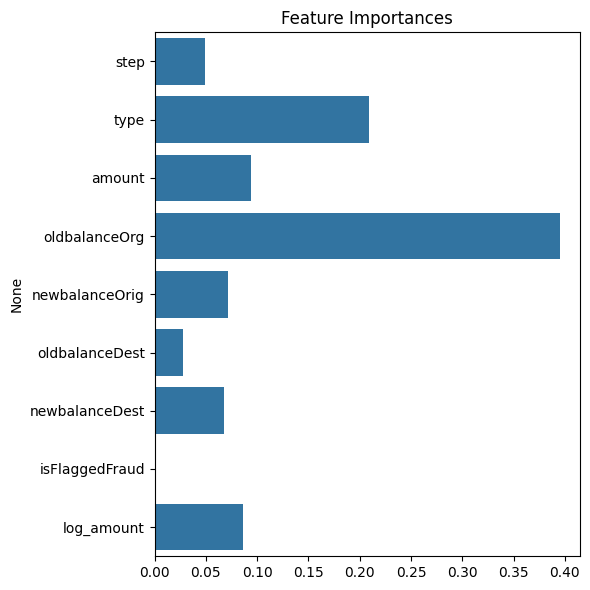

In [54]:
plt.figure(figsize=(6, 6))
sns.barplot(x=rf_model.feature_importances_, y=X.columns)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

Monitor and measure impact using key performance indicators (KPIs) such as:
1.Decrease in fraud rate: % of fraudulent transactions before vs after.
2.Reduction in financial losses due to fraud.
3. Precision and recall of model improve (fewer false positives and negatives).
4. Customer feedback: fewer complaints, fewer flagged accounts.

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight= (y == 0).sum() / (y == 1).sum(),
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

#Can try with Xgboost but the installation is taking time, can also do GridSearchCV to find best params 
#to improve Recall, but this takes a very long time as the dataset is huge.